## <center>Regresión con GAMs<br>(Generalized Additive Models)
    
### <center> Videos<br>[GAMs in Python (PyGAM)](https://youtu.be/XQ1vk7wEI7c)<br>[GAMs in R](https://www.youtube.com/watch?v=8doPTpkAWDQ)

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import compose
from sklearn import pipeline

In [2]:
#!pip install pygam

In [3]:
from pygam import LinearGAM   # GAM para regresión
from pygam import LogisticGAM # GAM para clasificación
from pygam import s, f        # s->spline for nums; f->factors for cats 

### Leer datos

In [4]:
# !wget -P ./../data/ https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/house-prices-train.csv

In [7]:
df = pd.read_csv("../data/house-prices-train.csv")
print("Filas dataset:", len(df))

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)
train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)
print("Filas train:", len(train_df))
print("Filas valid:", len(valid_df))

df.head(2)

Filas dataset: 1460
Filas train: 1168
Filas valid: 292


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


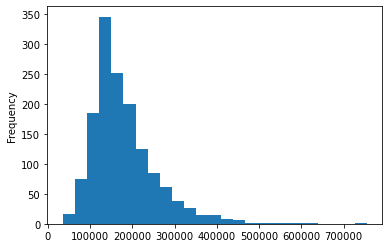

In [11]:
df.SalePrice.plot.hist(bins=25);

### Crear preprocesador

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
num_vars = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_vars = ["workclass","marital-status","occupation","relationship","race","gender","native-country"]  # quitar education
target   = "income"

# MENOS VARIABLES PARA SIMPLIFICAR
num_vars = ["age", "fnlwgt", "educational-num", "hours-per-week"]
cat_vars = ["gender", "race", "workclass", "marital-status", "occupation"]

In [6]:
x_preprocessing_nn = compose.ColumnTransformer(transformers=[
    ('cat', preprocessing.OneHotEncoder(),  cat_vars),
   #('num', preprocessing.StandardScaler(), num_vars),
   #('ord', preprocessing.OrdinalEncoder(), ord_feats)
], remainder='passthrough') #drop


x_preprocessing_tree = compose.ColumnTransformer(transformers=[
    ('cat', preprocessing.OrdinalEncoder(),  cat_vars),
   #('num', preprocessing.StandardScaler(), num_vars),
], remainder='passthrough') 


x_preprocessing = x_preprocessing_tree # LOS GAM NECESITAN EL MISMO PREPRO QUE LOS ARBOLES
y_preprocessing = preprocessing.LabelEncoder()

### Entrenar preprocesador

In [7]:
x = x_preprocessing.fit_transform(train_df[num_vars+cat_vars])
y = y_preprocessing.fit_transform(train_df["income"])

x_val = x_preprocessing.transform(valid_df[num_vars+cat_vars])
y_val = y_preprocessing.transform(valid_df["income"])

x.shape, x_val.shape

((4000, 9), (1000, 9))

In [8]:
categories = [c.tolist() for c in x_preprocessing.transformers_[0][1].categories_]
categories

[['Female', 'Male'],
 ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'],
 ['?',
  'Federal-gov',
  'Local-gov',
  'Private',
  'Self-emp-inc',
  'Self-emp-not-inc',
  'State-gov',
  'Without-pay'],
 ['Divorced',
  'Married-AF-spouse',
  'Married-civ-spouse',
  'Married-spouse-absent',
  'Never-married',
  'Separated',
  'Widowed'],
 ['?',
  'Adm-clerical',
  'Craft-repair',
  'Exec-managerial',
  'Farming-fishing',
  'Handlers-cleaners',
  'Machine-op-inspct',
  'Other-service',
  'Priv-house-serv',
  'Prof-specialty',
  'Protective-serv',
  'Sales',
  'Tech-support',
  'Transport-moving']]

In [9]:
x_df = pd.DataFrame(x, columns=cat_vars+num_vars)
x_df.head()

,gender,race,workclass,marital-status,occupation,age,fnlwgt,educational-num,hours-per-week
0,1.0,4.0,3.0,4.0,2.0,34.0,140011.0,8.0,45.0
1,1.0,4.0,3.0,4.0,5.0,24.0,219835.0,3.0,24.0
2,0.0,4.0,2.0,4.0,1.0,29.0,218650.0,9.0,40.0
3,0.0,4.0,2.0,0.0,7.0,29.0,141005.0,9.0,24.0
4,1.0,4.0,5.0,2.0,3.0,49.0,126077.0,8.0,35.0


### Crear GAM
- `l()` linear terms
- `s()` spline terms (numericas no lineales)
- `f()` factor terms (categorias o ordinales)
- `te()` tensor products
- `intercept`

In [10]:
gam = LogisticGAM(terms = f(0)+f(1)+f(2)+f(3)+f(4)+s(5)+s(6)+f(7)+s(8), n_splines=40)
gam

LogisticGAM(callbacks=['deviance', 'diffs', 'accuracy'], 
   fit_intercept=True, max_iter=100, n_splines=40, 
   terms=f(0) + f(1) + f(2) + f(3) + f(4) + s(5) + s(6) + f(7) + s(8),
   tol=0.0001, verbose=False)

### Entrenar GAM

In [11]:
%%time
#gam.fit(x.todense(), y)
#gam.fit(x, y)
#gam.fit(train_df[num_vars].values, y)
gam.gridsearch(x, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


CPU times: user 11 s, sys: 1.14 s, total: 12.2 s
Wall time: 5.85 s


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=f(0) + f(1) + f(2) + f(3) + f(4) + s(5) + s(6) + f(7) + s(8) + intercept,
   tol=0.0001, verbose=False)

In [12]:
vars = cat_vars+num_vars

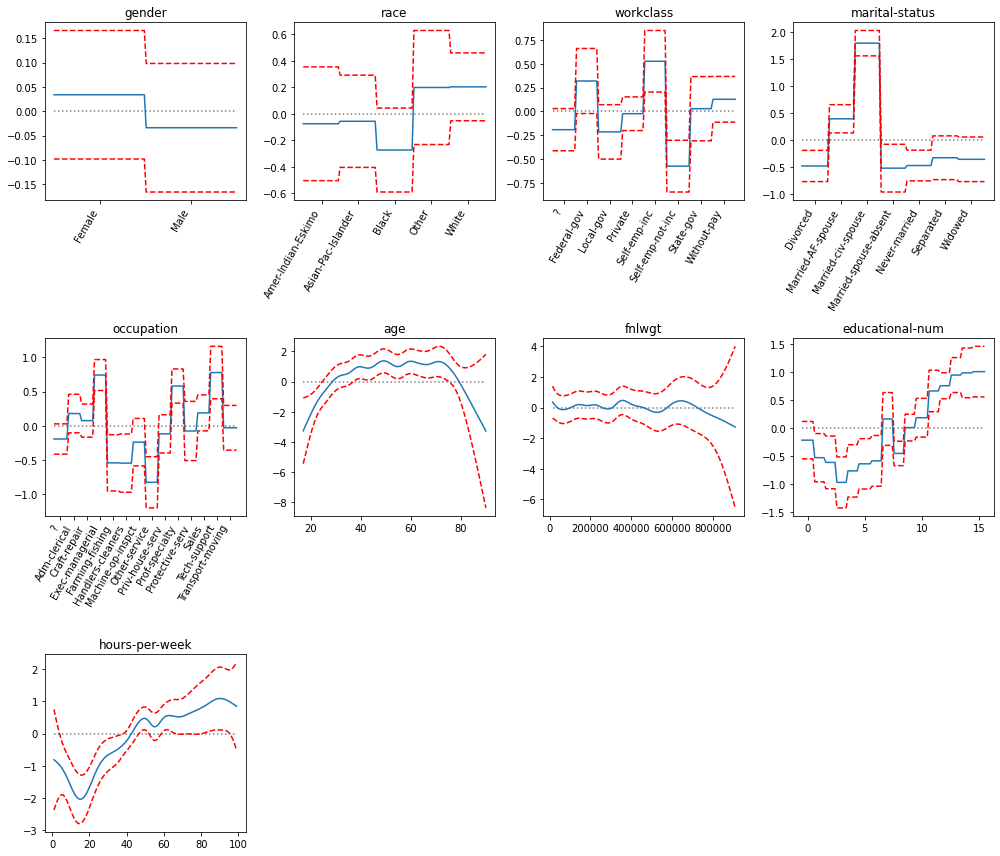

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec

N = len(vars)
cols = 4
rows = int(math.ceil(N / cols))
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(14, 12))

for i in range(N):
    ax = fig.add_subplot(gs[i])
    
    x_data = gam.generate_X_grid(term=i)[:, i]
    y_pdep, y_confi = gam.partial_dependence(term=i, width=.95)
    
    if i<len(cat_vars): # IF CATEGORY
        category = categories[i]
        ax.set_xticks(np.arange(len(category)))
        ax.set_xticklabels(labels=category, rotation=60, ha="right")

    ax.plot(x_data, np.zeros(100), c='grey', ls=':')
    ax.plot(x_data, y_pdep)
    ax.plot(x_data, y_confi, c='red', ls='--')
    ax.set_title(vars[i]);
    
    #ax.plot([1,2,3], [4,5,6], 'k.')

fig.tight_layout()

# Evaluar

In [15]:
pred = gam.predict(x_val)

In [16]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix

print("Accuracy:", accuracy_score(y_val, pred)*100)
print("Bal acc.:", balanced_accuracy_score(y_val, pred)*100)

Accuracy: 85.3
Bal acc.: 76.94182167077346


# Entrenar con todas las variables y todas las filas

In [17]:
df = pd.read_csv("../data/adult.csv")
print("Filas dataset:", len(df))

df["educational-num"] = df["educational-num"]-1
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)
train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)
print("Filas train:", len(train_df))
print("Filas valid:", len(valid_df))

df.head(2)

Filas dataset: 48842
Filas train: 39073
Filas valid: 9769


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,6,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,8,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K


In [18]:
num_vars = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_vars = ["workclass","marital-status","occupation","relationship","race","gender","native-country"]  # quitar education

x_preprocessing = compose.ColumnTransformer(transformers=[
    ('cat', preprocessing.OrdinalEncoder(),  cat_vars),
   #('num', preprocessing.StandardScaler(), num_vars),
], remainder='passthrough') 
y_preprocessing = preprocessing.LabelEncoder()

x = x_preprocessing.fit_transform(train_df[num_vars+cat_vars])
y = y_preprocessing.fit_transform(train_df["income"])

x_val = x_preprocessing.transform(valid_df[num_vars+cat_vars])
y_val = y_preprocessing.transform(valid_df["income"])

x.shape, x_val.shape

((39073, 13), (9769, 13))

In [19]:
x_df = pd.DataFrame(x, columns=cat_vars+num_vars)
x_df.head()

,workclass,marital-status,occupation,relationship,race,gender,native-country,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,0.0,4.0,0.0,3.0,2.0,0.0,39.0,20.0,298155.0,9.0,0.0,0.0,40.0
1,4.0,2.0,3.0,0.0,4.0,1.0,39.0,42.0,180985.0,10.0,0.0,0.0,52.0
2,7.0,0.0,13.0,4.0,4.0,0.0,39.0,35.0,483530.0,9.0,0.0,0.0,40.0
3,0.0,0.0,0.0,4.0,4.0,0.0,39.0,39.0,142804.0,8.0,0.0,0.0,16.0
4,4.0,4.0,10.0,1.0,4.0,1.0,39.0,24.0,354351.0,12.0,0.0,0.0,40.0


In [20]:
gam = LogisticGAM(terms = f(0)+f(1)+f(2)+f(3)+f(4)+f(5)+f(6)+\
                          s(7)+s(8)+f(9)+s(10)+s(11)+s(12))
gam

LogisticGAM(callbacks=['deviance', 'diffs', 'accuracy'], 
   fit_intercept=True, max_iter=100, 
   terms=f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + s(7) + s(8) + f(9) + s(10) + s(11) + s(12),
   tol=0.0001, verbose=False)

In [21]:
%%time
#gam.fit(x, y)
gam.gridsearch(x, y)

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)
/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
/usr/local/lib/py

did not converge


/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask

did not converge


/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask

did not converge


/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask

did not converge


/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask

did not converge


/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask

did not converge


/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(weights) >= np.sqrt(EPS)) * np.isfinite(weights)
/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: ov

did not converge


/usr/local/lib/python3.7/site-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.7/site-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: invalid value encountered in multiply
  self.distribution.V(mu=mu) *
/usr/local/lib/python3.7/site-packages/pygam/pygam.py:614: RuntimeWarning: invalid value encountered in greater_equal
  mask

CPU times: user 6min 38s, sys: 34.1 s, total: 7min 12s
Wall time: 3min 59s


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + s(7) + s(8) + f(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False)

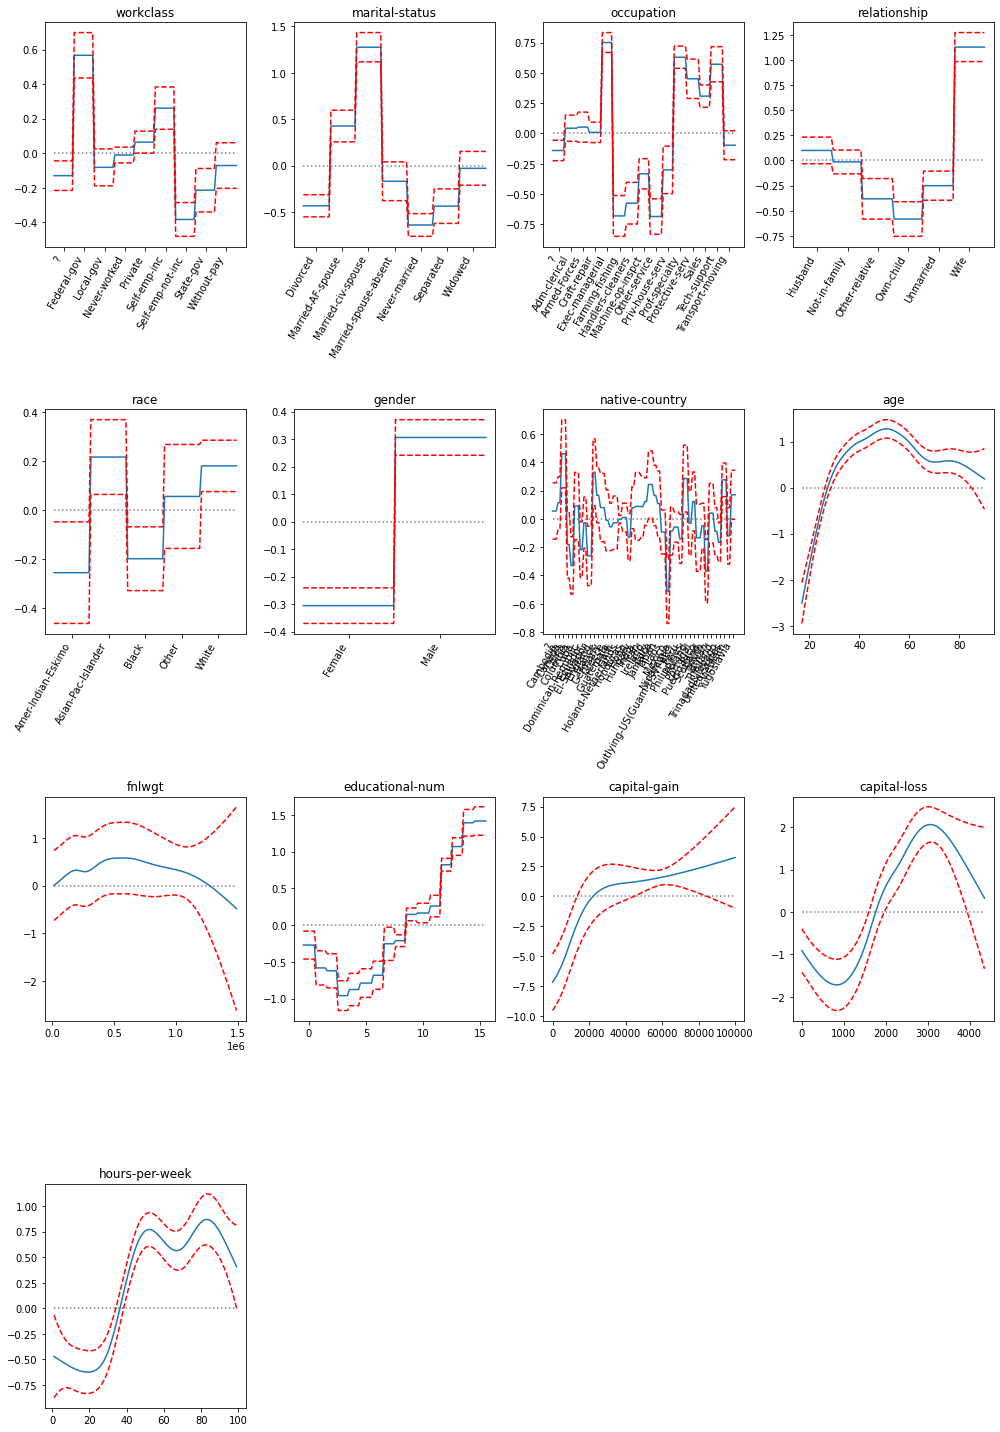

In [22]:
categories = [c.tolist() for c in x_preprocessing.transformers_[0][1].categories_]
vars = cat_vars+num_vars

N = len(vars)
cols = 4
rows = int(math.ceil(N / cols))
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(14, 20))

for i in range(N):
    ax = fig.add_subplot(gs[i])
    
    x_data = gam.generate_X_grid(term=i)[:, i]
    y_pdep, y_confi = gam.partial_dependence(term=i, width=.95)
    
    if i<len(cat_vars): # IF CATEGORY
        category = categories[i]
        ax.set_xticks(np.arange(len(category)))
        ax.set_xticklabels(labels=category, rotation=60, ha="right")

    ax.plot(x_data, np.zeros(100), c='grey', ls=':')
    ax.plot(x_data, y_pdep)
    ax.plot(x_data, y_confi, c='red', ls='--')
    ax.set_title(vars[i]);

fig.tight_layout()

# Evaluar 25 splines

In [23]:
pred = gam.predict(x_val)

In [24]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix

print("Accuracy:", accuracy_score(y_val, pred)*100)
print("Bal acc.:", balanced_accuracy_score(y_val, pred)*100)

Accuracy: 85.72013512130208
Bal acc.: 77.40550259960366


# Evaluar 40 splines

In [30]:
pred = gam.predict(x_val)

In [31]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix

print("Accuracy:", accuracy_score(y_val, pred)*100)
print("Bal acc.:", balanced_accuracy_score(y_val, pred)*100)

Accuracy: 86.41621455624936
Bal acc.: 78.62017329161117
